# Notebook to inspect data for Olympic Mountain Range 

# Step 0 Set up Notebook 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr 
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from snowML.datapipe.utils import data_utils as du 
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import snow_types as st 
from snowML.datapipe import get_lidar_data as lidar
from snowML.viz import vis_utils as vu
from snowML.LSTM import LSTM_plot3 as plot3
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from snowML.LSTM import LSTM_evaluate as evaluate
#from snowML.LSTM import LSTM_metrics as metrics

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Step 1 Define Olympic Maritime Hucs 

In [3]:
huc_olympics_maritime = ['171001020201','171001020401', '171001020402','171001020404','171001020405','171100170201', '171100180401', '171100180501',
 '171100180502', '171100200303','171100200304','171100200305','171100200501','171100200502','171100200503','171100200504','171100200506','171100200507',
 '171100200508','171100200509','171100200510','171100210201']

In [4]:
len(huc_olympics_maritime)

22

# Step 2: Get UA Data 

In [5]:
def filter_by_date (df, filter_date_start, filter_date_end = None):
    df_filtered = df[df.index >= filter_date_start]
    if filter_date_end is not None: 
        df_filtered = df_filtered[df_filtered.index <= filter_date_end]
    return df_filtered

In [6]:
def get_UA_swe(huc_id, filter_date): 
    f = f"mean_swe_in_{huc_id}.csv"
    b = "snowml-gold"
    df_UA = du.s3_to_df(f, b)
    df_UA['day'] = pd.to_datetime(df_UA['day'])
    df_UA = df_UA.set_index("day")
    df_UA["mean_swe"] = df_UA["mean_swe"]/1000
    df_UA = filter_by_date(df_UA, filter_date)
    return df_UA

In [7]:
#example 
huc_id = huc_olympics_maritime[0] 
filter_date_start = "2013-01-01"
df_UA = get_UA_swe(huc_id, filter_date_start)
df_UA.head()

,mean_swe,huc_id
day,,
2013-01-01,0.586545,171001020201
2013-01-02,0.585091,171001020201
2013-01-03,0.578909,171001020201
2013-01-04,0.581636,171001020201
2013-01-05,0.580909,171001020201


# Step 3 - Get Lidar Data

In [8]:
ds_lidar = lidar.get_lidar_all("USWAOL", bucket_name = None)
ds_lidar

QUEUEING TASKS | :   0%|          | 0/304 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/304 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/304 [00:00<?, ?it/s]

{'20160208': 'lidar_data/ASO_50M_SWE_USWAOL_20160208.tif', '20160329': 'lidar_data/ASO_50M_SWE_USWAOL_20160329.tif'}
Warning - have you verified the EPSG for this prefix?
Warning - have you verified the EPSG for this prefix?
The file already exists at s3://snowml-bronze/lidar_USWAOL.zarr. Skipping the save.


<xarray.Dataset> Size: 15MB
Dimensions:      (day: 2, y: 1015, x: 1792)
Coordinates:
  * day          (day) object 16B '20160208' '20160329'
  * x            (x) float64 14kB -124.2 -124.2 -124.2 ... -123.1 -123.1 -123.1
  * y            (y) float64 8kB 47.49 47.49 47.49 47.49 ... 48.09 48.09 48.09
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    SWE          (day, y, x) float32 15MB nan nan nan nan ... 8.787e-05 nan nan

In [9]:
# look at a subset by huc 
clipped = lidar.subset_by_huc(ds_lidar, huc_id)
lidar.count_na(clipped)
clipped

for day All:
Number of NaN values: 87194
Percent of NaN values: 48.60%


<xarray.Dataset> Size: 722kB
Dimensions:      (day: 2, x: 345, y: 260)
Coordinates:
  * day          (day) object 16B '20160208' '20160329'
  * x            (x) float64 3kB -123.8 -123.8 -123.8 ... -123.6 -123.6 -123.6
  * y            (y) float64 2kB 47.65 47.65 47.65 47.65 ... 47.8 47.8 47.8 47.8
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    SWE          (day, y, x) float32 718kB nan nan nan nan ... nan nan nan nan

In [10]:
#lidar.plot_valid_pixels(clipped)

In [11]:
df_Lidar = lidar.calc_mean(clipped)
df_Lidar.head(2)

,mean_swe_lidar
day,
2016-02-08,0.259178
2016-03-29,0.791301


In [12]:
# merge the lidar data into the df_UA df as column "mean_swe_lidar"
df_joined = df_UA.join(df_Lidar, how='outer')

In [13]:
# create a small df that only has rows w/lidar data 
df_joined_small = df_joined[df_joined["mean_swe_lidar"].notna()]
df_joined_small.head(2)

,mean_swe,huc_id,mean_swe_lidar
day,,,
2016-02-08,0.569636,171001020201,0.259178
2016-03-29,0.732000,171001020201,0.791301


# Step 4 Get SWE Data UCLA 

In [14]:
def get_UCLA_swe(huc_id, filter_date_start):
    f = f"mean_swe_ucla_2_in_{huc_id}.csv" 
    #f = f"mean_swe_in_{huc_id}_UCLA.csv"
    b = "snowml-gold"
   
    if du.isin_s3(b, f): 
        df_UCLA = du.s3_to_df(f, b)
    else: 
        df_UCLA = ucla.get_gold_df(huc_id, year_start, year_end, overwrite = False)
    
    df_UCLA['day'] = pd.to_datetime(df_UCLA['day'])
    df_UCLA = df_UCLA.set_index("day")
    df_UCLA = filter_by_date(df_UCLA, filter_date_start)
    return df_UCLA

In [15]:
df_UCLA = get_UCLA_swe(huc_id, filter_date_start)
df_UCLA.head(2)

,SWE_Post
day,
2013-01-01,0.863308
2013-01-02,0.863219


# Step 5 - PLot

In [16]:
# custom assemble plot function; but use plot3 module plot3b function 
def assemble_plot_dict(y_vals, color, label, n_offset=0, sparse = False):
    plot_dict = {}
    plot_dict["y_axis_vals"] = np.concatenate([np.full(n_offset, np.nan), y_vals])
    plot_dict["color"] = color
    plot_dict["label"] = label
    plot_dict["sparse"] = sparse
    return plot_dict

In [17]:
def compile_plot_data(df_UA, df_joined, df_UCLA):
    x_axis_vals = df_UA.index.to_list()
    UA_dict = assemble_plot_dict(df_UA["mean_swe"], "blue", "UA_data (Physics Based Model Prediction")
    Lidar_dict = assemble_plot_dict(df_joined["mean_swe_lidar"], "red", "Lidar data", sparse = True)
    
    # Pad the UCLA data with zeros so the plot fits 
    num_zeros = len(x_axis_vals) - len(df_UCLA["SWE_Post"])
    extended_series = pd.concat([
        df_UCLA["SWE_Post"],
        pd.Series([0] * num_zeros, index=x_axis_vals[len(df_UCLA["SWE_Post"]):])
        ])
    UCLA_dict = assemble_plot_dict(extended_series, "black", "UCLA Model Data")
    y_dict_list = [UA_dict, Lidar_dict, UCLA_dict]
    
    return x_axis_vals, y_dict_list

In [18]:
def compile_plot_data_filtered(df_UA, df_joined, df_UCLA, filter_date_start = "2015-10-01", filter_date_end = "2016-09-30"):
    df_UA_slim = filter_by_date(df_UA, filter_date_start, filter_date_end = filter_date_end)
    df_joined_slim = filter_by_date(df_joined, filter_date_start, filter_date_end = filter_date_end)
    df_UCLA_slim = filter_by_date(df_UCLA, filter_date_start, filter_date_end = filter_date_end)
    x_axis_vals, y_dict_list = compile_plot_data(df_UA_slim, df_joined_slim, df_UCLA_slim)
    return x_axis_vals, y_dict_list
   
    

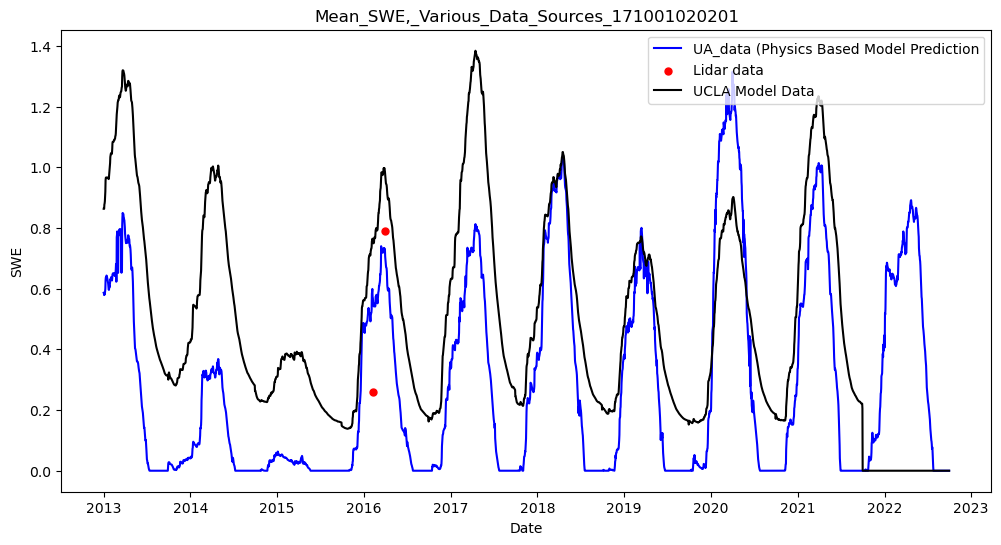

In [19]:
ttl = f"Mean_SWE,_Various_Data_Sources_{huc_id}"
x_axis_vals, y_dict_list = compile_plot_data(df_UA, df_joined, df_UCLA)
plt = plot3.plot3b(x_axis_vals, y_dict_list, ttl)
plt.show()
plt.close()

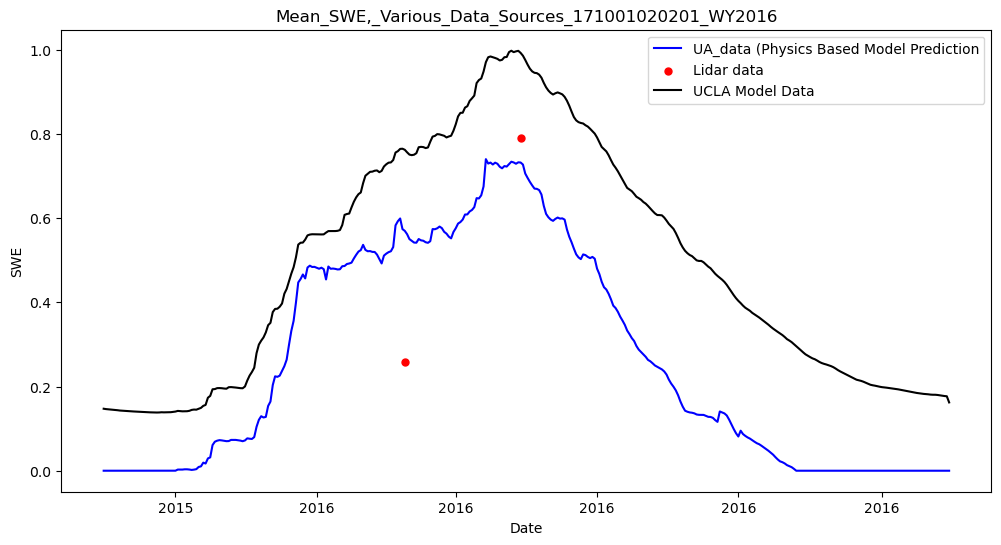

In [20]:
ttl = f"Mean_SWE,_Various_Data_Sources_{huc_id}_WY2016"
x_axis_vals, y_dict_list = compile_plot_data_filtered(df_UA, df_joined, df_UCLA)
plt = plot3.plot3b(x_axis_vals, y_dict_list, ttl)
plt.show()
plt.close()

# Step 6 - Calulate MSE / MAE 

In [21]:
def calc_diff(df_joined, df_UCLA):
    
    df_joined_small = df_joined[df_joined["mean_swe_lidar"].notna()]
    df_small_all = df_joined_small.join(df_UCLA, how='inner')
    lidar_dat = list(df_small_all["mean_swe_lidar"])
    UA_dat = list(df_small_all["mean_swe"])
    UCLA_dat = list(df_small_all["SWE_Post"])
    mse_UCLA = mean_squared_error(lidar_dat, UCLA_dat)
    mae_UCLA = mean_absolute_error(lidar_dat, UCLA_dat)
    mse_UA = mean_squared_error(lidar_dat, UA_dat)
    mae_UA = mean_absolute_error(lidar_dat, UA_dat)

    huc = str(int((df_joined_small.iloc[0]["huc_id"])))


    result = pd.DataFrame(
        {
            "mse_UCLA": [mse_UCLA],
            "mae_UCLA": [mae_UCLA],
            "mse_UA": [mse_UA],
            "mae_UA": [mae_UA]
        },
        index=[huc]
    )
    return result

In [22]:
calc_diff(df_joined_small, df_UCLA)


,mse_UCLA,mae_UCLA,mse_UA,mae_UA
171001020201,0.146743,0.352055,0.04995,0.18488


# Step 7 - Putting it all together

In [23]:
def plot_all(huc_list, filter_date_start = "2013-01-01"): 

    df_results = pd.DataFrame(columns=["mse_UCLA", "mae_UCLA", "mse_UA", "mae_UA"])

    for huc_id in huc_list: 
        df_UA = get_UA_swe(huc_id, filter_date_start)
        clipped = lidar.subset_by_huc(ds_lidar, huc_id)
        df_Lidar = lidar.calc_mean(clipped)
        df_joined = df_UA.join(df_Lidar, how='outer')
        df_UCLA = get_UCLA_swe(huc_id, filter_date_start)

        # calc stats
        stats = calc_diff(df_joined, df_UCLA)
        df_results = df_results = pd.concat([df_results, stats])
        
        # plot 
        ttl = f"Mean_SWE,_Various_Data_Sources_{huc_id}"
        x_axis_vals, y_dict_list = compile_plot_data(df_UA, df_joined, df_UCLA)
        plt = plot3.plot3b(x_axis_vals, y_dict_list, ttl)
        f_out = f"charts/UA_UCLA_and_Lidar_{huc_id}"
        #plt.show()
        plt.savefig(f_out + ".png", dpi=300, bbox_inches='tight')
        plt.close()
        x_axis_vals_small , y_dict_list_small = compile_plot_data_filtered(df_UA, df_joined, df_UCLA)
        ttl2 = f"Mean_SWE,_Various_Data_Sources_{huc_id}_WY2016"
        f_out2 = f"charts/WY2015/UA_UCLA_and_Lidar_{huc_id}_WY2015"
        plt = plot3.plot3b(x_axis_vals_small, y_dict_list_small, ttl2)
        #plt.show()
        plt.savefig(f_out2 + ".png", dpi=300, bbox_inches='tight')
        plt.close()

    return df_results
        
    
  

In [27]:
def label_best_model(df_stats):
    df_stats = df_stats.copy()  # Avoid modifying the original DataFrame

    df_stats["best mse"] = df_stats.apply(
        lambda row: "UCLA" if row["mse_UCLA"] < row["mse_UA"] else "UA", axis=1
    )

    df_stats["best mae"] = df_stats.apply(
        lambda row: "UCLA" if row["mae_UCLA"] < row["mae_UA"] else "UA", axis=1
    )

    return df_stats


In [29]:
df_stats = plot_all(huc_olympics_maritime)
df_stats

,mse_UCLA,mae_UCLA,mse_UA,mae_UA
171001020201,0.146743,0.352055,0.049950,0.184880
171001020401,0.010852,0.087534,0.052581,0.228819
171001020402,0.044526,0.204696,0.092295,0.277874
171001020404,0.022274,0.133161,0.038321,0.156969
171001020405,0.068857,0.240524,0.051633,0.187815
171100170201,0.005051,0.060361,0.047386,0.199678
171100180401,0.010729,0.093635,0.036726,0.191614
171100180501,0.010694,0.098137,0.099401,0.307393
171100180502,0.013680,0.110913,0.088080,0.293983
171100200303,0.019799,0.140482,0.161028,0.387954


In [30]:
df_stats.describe()

,mse_UCLA,mae_UCLA,mse_UA,mae_UA
count,22.000000,22.000000,22.000000,22.000000
mean,0.027893,0.132683,0.085515,0.237987
std,0.034436,0.082246,0.098377,0.154778
min,0.001814,0.038771,0.001087,0.030464
25%,0.006434,0.072639,0.024773,0.124660
50%,0.012266,0.104525,0.050055,0.196403
75%,0.041195,0.171757,0.097625,0.304040
max,0.146743,0.352055,0.392320,0.619113


In [31]:
df_stats_label  = label_best_model(df_stats)
df_stats_label 

,mse_UCLA,mae_UCLA,mse_UA,mae_UA,best mse,best mae
171001020201,0.146743,0.352055,0.049950,0.184880,UA,UA
171001020401,0.010852,0.087534,0.052581,0.228819,UCLA,UCLA
171001020402,0.044526,0.204696,0.092295,0.277874,UCLA,UCLA
171001020404,0.022274,0.133161,0.038321,0.156969,UCLA,UCLA
171001020405,0.068857,0.240524,0.051633,0.187815,UA,UA
171100170201,0.005051,0.060361,0.047386,0.199678,UCLA,UCLA
171100180401,0.010729,0.093635,0.036726,0.191614,UCLA,UCLA
171100180501,0.010694,0.098137,0.099401,0.307393,UCLA,UCLA
171100180502,0.013680,0.110913,0.088080,0.293983,UCLA,UCLA
171100200303,0.019799,0.140482,0.161028,0.387954,UCLA,UCLA
